In [129]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
import tensorflow as tf
from datetime import datetime
import keras
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')


plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

%matplotlib inline

In [130]:
from sklearn.externals import joblib 
#load normalizer
y_scaler = joblib.load('price_normalizer.pkl') 

### 3) Build and train an RNN model with a GRU layer and print the train and validation loss

In [131]:
X_test_lagged = pd.read_csv('../models/X_test_lagged.csv',index_col = 0)
X_train_lagged = pd.read_csv('../models/X_train_lagged.csv',index_col = 0)
X_valid_lagged = pd.read_csv('../models/X_valid_lagged.csv',index_col = 0)

Y_test_leading = pd.read_csv('../models/Y_test_leading.csv',index_col = 0)
Y_train_leading = pd.read_csv('../models/Y_train_leading.csv',index_col = 0)
Y_valid_leading = pd.read_csv('../models/Y_valid_leading.csv',index_col = 0)

In [132]:
N=6
# reshape input to be 3D [samples, time steps, features]
X_train_lagged = X_train_lagged.values.reshape((X_train_lagged.shape[0], N, int(X_train_lagged.shape[1]/N)))
X_valid_lagged = X_valid_lagged.values.reshape((X_valid_lagged.shape[0], N, int(X_valid_lagged.shape[1]/N)))
print(X_train_lagged.shape, Y_train_leading.shape, X_valid_lagged.shape, Y_valid_leading.shape)

(2862, 6, 13) (2862, 7) (171, 6, 13) (171, 7)


In [133]:
#gru
keras.backend.clear_session()
model_gru = Sequential()
model_gru.add(GRU(50,input_shape=(X_train_lagged.shape[1], X_train_lagged.shape[2])))
model_gru.add(Dense(units=7))
model_gru.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 50)                9600      
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 357       
Total params: 9,957
Trainable params: 9,957
Non-trainable params: 0
_________________________________________________________________


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x1335a63c8>>
Traceback (most recent call last):
  File "/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1467, in __del__
    self._session._session, self._handle, status)
  File "/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 519, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 140613745948528


In [134]:
# fit network
gru_history = model_gru.fit(X_train_lagged, Y_train_leading, epochs=50, batch_size=20, validation_data=(X_valid_lagged, Y_valid_leading), shuffle=False)


Train on 2862 samples, validate on 171 samples
Epoch 1/50
2862/2862 [==============================] - 2s 628us/step - loss: 0.2028 - acc: 0.1223 - val_loss: 0.5804 - val_acc: 0.2047
Epoch 2/50
2862/2862 [==============================] - 1s 317us/step - loss: 0.2336 - acc: 0.1471 - val_loss: 0.4336 - val_acc: 0.2456
Epoch 3/50
2862/2862 [==============================] - 1s 319us/step - loss: 0.1404 - acc: 0.1314 - val_loss: 0.3925 - val_acc: 0.1813
Epoch 4/50
2862/2862 [==============================] - 1s 313us/step - loss: 0.1455 - acc: 0.1572 - val_loss: 0.3493 - val_acc: 0.0819
Epoch 5/50
2862/2862 [==============================] - 1s 314us/step - loss: 0.1063 - acc: 0.1513 - val_loss: 0.3533 - val_acc: 0.0994
Epoch 6/50
2862/2862 [==============================] - 1s 313us/step - loss: 0.1066 - acc: 0.1408 - val_loss: 0.3401 - val_acc: 0.0994
Epoch 7/50
2862/2862 [==============================] - 1s 315us/step - loss: 0.1075 - acc: 0.1590 - val_loss: 0.3522 - val_acc: 0.0877
E

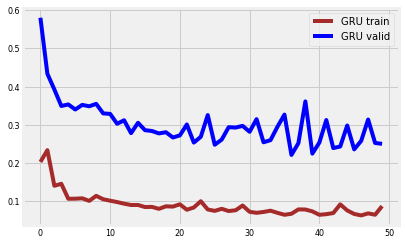

In [135]:
pyplot.plot(gru_history.history['loss'], label='GRU train', color='brown')
pyplot.plot(gru_history.history['val_loss'], label='GRU valid', color='blue')
pyplot.legend()
pyplot.show()

In [136]:
scores = model_gru.evaluate(X_valid_lagged, Y_valid_leading, verbose=0)
print("Accuracy: " + str(scores))

Accuracy: [0.2501841626669231, 0.16959064362341897]


In [ ]:
y_valid_pred = model_gru.predict(X_valid_lagged)
unnorm_y_valid_pred = y_scaler.inverse_transform(y_valid_pred)
unnorm_y_valid = y_scaler.inverse_transform(Y_valid_leading)
plt.figure(figsize=(16,6))
plt.title('RNN GRU Model Validation Predictions(t+1)')
sns.lineplot(Y_valid_leading.index, unnorm_y_valid_pred[:,0], label='predicted price t+1')
sns.lineplot(Y_valid_leading.index, unnorm_y_valid[:, 0], label='actual price')
plt.xlabel('date')


Text(0.5, 0, 'date')

### 4) Build and train an RNN model with a GRU layer and recurrent dropout and print the train and validation loss for each epoch

In [ ]:
#gru
keras.backend.clear_session()
model_gru2 = Sequential()
model_gru2.add(GRU(500,recurrent_dropout=0.5, input_shape=(X_train_lagged.shape[1], X_train_lagged.shape[2])))
model_gru2.add(Dense(units=7))
model_gru2.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model_gru2.summary()

In [ ]:
# fit network
gru_history = model_gru2.fit(X_train_lagged, Y_train_leading,epochs=20, batch_size=150,
                             validation_data=(X_valid_lagged, Y_valid_leading), shuffle=False)


In [ ]:
pyplot.plot(gru_history.history['loss'], label='GRU train', color='brown')
pyplot.plot(gru_history.history['val_loss'], label='GRU valid', color='blue')
pyplot.legend()
pyplot.show()

In [ ]:
scores = model_gru2.evaluate(X_valid_lagged, Y_valid_leading, verbose=0)
print("Accuracy: " + str(scores))

In [ ]:
y_valid_pred = model_gru2.predict(X_valid_lagged)
unnorm_y_valid_pred = y_scaler.inverse_transform(y_valid_pred)
plt.figure(figsize=(16,6))
plt.title('RNN GRU and Recurrent dropout Model Validation Predictions(t+1)')
sns.lineplot(Y_valid_leading.index, unnorm_y_valid_pred[:,0], label='predicted price t+1')
sns.lineplot(Y_valid_leading.index, unnorm_y_valid[:, 0], label='actual price')
plt.xlabel('date')


### 6) Add an additional GRU layer to (5) above with dropout and recurrent dropout and print train and validation loss

In [ ]:
#gru
keras.backend.clear_session()
model_gru3 = Sequential()
model_gru3.add(GRU(50,recurrent_dropout=0.2, input_shape=(X_train_lagged.shape[1], X_train_lagged.shape[2])))
model_gru3.add(Dense(units=7))
model_gru3.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model_gru3.summary()

In [ ]:
gru_history = model_gru3.fit(X_train_lagged, Y_train_leading, epochs=20, batch_size=150, validation_data=(X_valid_lagged, Y_valid_leading), shuffle=False)
